# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

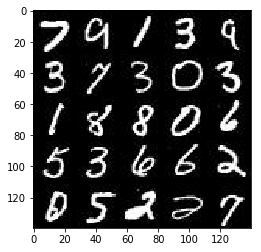

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

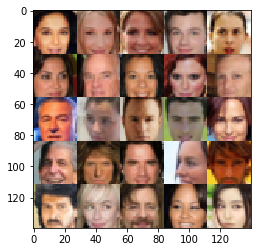

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [15]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input')
    z = tf.placeholder(tf.float32, (None, z_dim), name = 'z')
    lr = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs, z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        x1 = tf.layers.conv2d(images, filters=64, kernel_size=5, strides=2,padding='SAME')
        #no batch normalization on 1st layer
        relux1 = tf.maximum(alpha*x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(relux1, filters=128, kernel_size=5, strides=2,padding='SAME')
        batchx2 = tf.layers.batch_normalization(x2, training=True)
        relux2 = tf.maximum(alpha*batchx2, batchx2)
        #7x7x128
        
        x3 = tf.layers.conv2d(relux2, filters=256, kernel_size=5, strides=2,padding='SAME')
        batchx3 = tf.layers.batch_normalization(x3, training=True)
        relux3 = tf.maximum(alpha*batchx3, batchx3)
        #4x4x256
        
        x4 = tf.reshape(relux3, (-1, 4*4* 256 ))
        logits = tf.layers.dense(x4, 1)
        output = tf.sigmoid(logits)
        
        

    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [17]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        relux1 = tf.maximum(alpha*x1, x1)
        #7 x 7 x 512 now
        
        x2 = tf.layers.conv2d_transpose(relux1, filters=256, kernel_size=5, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        relux2 = tf.maximum(alpha*x2, x2)
        # 7 x 7 x 256 now

        
        x3 = tf.layers.conv2d_transpose(relux2, filters=128, kernel_size=5, strides=2, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        relux3 = tf.maximum(alpha*x3, x3)
        # 14 x 14 128 now
        
        # Output layer, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(relux3, filters=out_channel_dim, kernel_size=5, strides=2, padding='SAME')
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [18]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, img_width, img_height, channels = data_shape

    input_real, input_z, lr = model_inputs(img_width, img_height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    generator_output_every = 100
    print_output_every = 2

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                #images given are between -0.5 to 0.5. for tanh should be rescaled to -1,1
                batch_images = batch_images * 2
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})


                if steps % print_output_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % generator_output_every == 0:
                    show_generator_output(sess, 16, input_z, channels, data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [22]:
print(mnist_dataset.shape)

NameError: name 'mnist_dataset' is not defined

Epoch 1/2... Discriminator Loss: 4.9329... Generator Loss: 0.0119
Epoch 1/2... Discriminator Loss: 2.5072... Generator Loss: 0.2459
Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 2.0263... Generator Loss: 0.2339
Epoch 1/2... Discriminator Loss: 1.6375... Generator Loss: 0.3250
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.4232
Epoch 1/2... Discriminator Loss: 1.3452... Generator Loss: 0.4840
Epoch 1/2... Discriminator Loss: 0.8518... Generator Loss: 0.9507
Epoch 1/2... Discriminator Loss: 0.9021... Generator Loss: 0.8227
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 0.5314
Epoch 1/2... Discriminator Loss: 2.0480... Generator Loss: 0.1877
Epoch 1/2... Discriminator Loss: 1.6588... Generator Loss: 0.2706
Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 0.6277
Epoch 1/2... Discriminator Loss: 2.5114... Generator Loss: 0.1112
Epoch 1/2... Discriminator Loss: 1.9565... Generator Loss: 0.2411
Epoch 1/2.

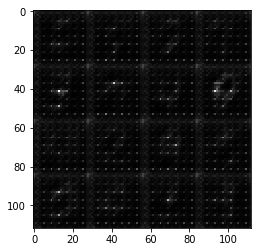

Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.0357... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 0.8733... Generator Loss: 1.3020
Epoch 1/2... Discriminator Loss: 1.3220... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.5832... Generator Loss: 0.4273
Epoch 1/2... Discriminator Loss: 1.3845... Generator Loss: 0.5076
Epoch 1/2... Discriminator Loss: 1.3602... Generator Loss: 0.4711
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.8324
Epoch 1/2... Discriminator Loss: 1.3515... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.6534
Epoch 1/2... Discriminator Loss: 1.5374... Generator Loss: 0.3641
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.5285
Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 0.7078
Epoch 1/2.

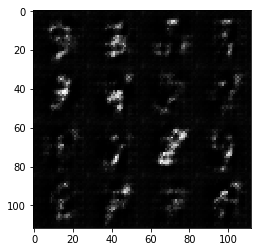

Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 0.9274... Generator Loss: 0.7724
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.3702
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 0.4957
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 1.1152
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 1.6539
Epoch 1/2... Discriminator Loss: 1.2666... Generator Loss: 1.9823
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.3169
Epoch 1/2... Discriminator Loss: 0.9648... Generator Loss: 1.6061
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 1.4978
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 1.0465
Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 1.0946
Epoch 1/2... Discriminator Loss: 0.9010... Generator Loss: 0.9511
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 0.6205
Epoch 1/2.

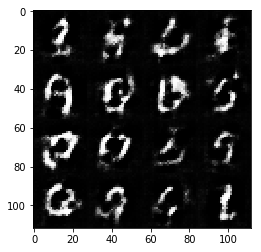

Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.1746
Epoch 1/2... Discriminator Loss: 1.0556... Generator Loss: 1.8952
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 1.8167
Epoch 1/2... Discriminator Loss: 0.8911... Generator Loss: 1.3666
Epoch 1/2... Discriminator Loss: 1.0643... Generator Loss: 1.6528
Epoch 1/2... Discriminator Loss: 1.0908... Generator Loss: 1.5913
Epoch 1/2... Discriminator Loss: 0.8107... Generator Loss: 1.4899
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 1.3447
Epoch 1/2... Discriminator Loss: 0.9042... Generator Loss: 1.1327
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 0.9590... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 0.8393... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.4212
Epoch 1/2.

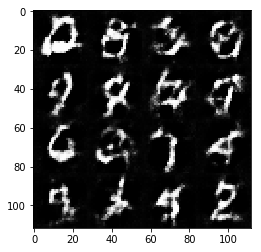

Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 1.1784... Generator Loss: 0.4962
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.4723
Epoch 1/2... Discriminator Loss: 1.0167... Generator Loss: 1.3301
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 1.7185
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 1.5236
Epoch 1/2... Discriminator Loss: 0.9421... Generator Loss: 0.9428
Epoch 1/2... Discriminator Loss: 1.1085... Generator Loss: 0.6386
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 0.5166
Epoch 1/2... Discriminator Loss: 0.9833... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 0.7417
Epoch 1/2... Discriminator Loss: 1.1268... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.8604
Epoch 1/2.

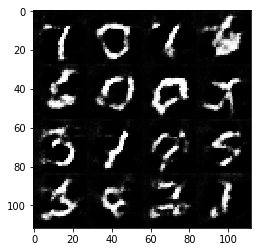

Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 1.4086
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 1.3277
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 1.4081
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 1.2400
Epoch 1/2... Discriminator Loss: 1.1059... Generator Loss: 1.5545
Epoch 1/2... Discriminator Loss: 1.0839... Generator Loss: 1.5514
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 1.1033
Epoch 1/2... Discriminator Loss: 1.0128... Generator Loss: 1.2241
Epoch 1/2... Discriminator Loss: 0.9601... Generator Loss: 1.3972
Epoch 1/2... Discriminator Loss: 0.9611... Generator Loss: 1.4572
Epoch 1/2... Discriminator Loss: 0.7578... Generator Loss: 1.1270
Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 1.1749
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 1.1894
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 1.1915
Epoch 1/2.

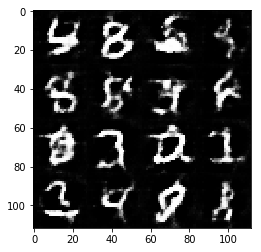

Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.4049
Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 0.4221
Epoch 1/2... Discriminator Loss: 1.1616... Generator Loss: 0.5907
Epoch 1/2... Discriminator Loss: 1.0063... Generator Loss: 0.8909
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 1.6829
Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.6153
Epoch 1/2... Discriminator Loss: 0.8988... Generator Loss: 1.1546
Epoch 1/2... Discriminator Loss: 1.0523... Generator Loss: 1.1646
Epoch 1/2... Discriminator Loss: 0.9419... Generator Loss: 1.3735
Epoch 1/2... Discriminator Loss: 0.8697... Generator Loss: 1.1359
Epoch 1/2... Discriminator Loss: 1.0688... Generator Loss: 1.5646
Epoch 1/2... Discriminator Loss: 0.9168... Generator Loss: 1.3277
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 0.7065
Epoch 1/2... Discriminator Loss: 0.9644... Generator Loss: 1.2104
Epoch 1/2... Discriminator Loss: 0.8643... Generator Loss: 1.3207
Epoch 1/2.

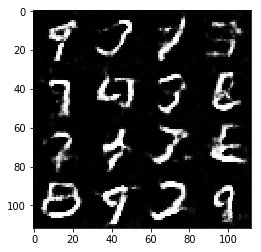

Epoch 1/2... Discriminator Loss: 0.9927... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 0.9866... Generator Loss: 1.0111
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 1.5240
Epoch 1/2... Discriminator Loss: 1.2505... Generator Loss: 2.0690
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 1.6618
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 1.3719
Epoch 1/2... Discriminator Loss: 0.9779... Generator Loss: 1.1114
Epoch 1/2... Discriminator Loss: 1.0359... Generator Loss: 1.4991
Epoch 1/2... Discriminator Loss: 1.1481... Generator Loss: 1.4688
Epoch 1/2... Discriminator Loss: 0.9470... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 1.0428... Generator Loss: 0.6732
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 0.7010
Epoch 1/2... Discriminator Loss: 1.0280... Generator Loss: 0.7549
Epoch 1/2... Discriminator Loss: 1.0410... Generator Loss: 0.7904
Epoch 1/2... Discriminator Loss: 0.9486... Generator Loss: 0.9897
Epoch 1/2.

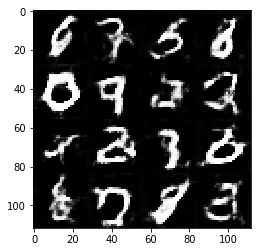

Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 2.3400
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.4684
Epoch 1/2... Discriminator Loss: 1.0863... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 0.8752... Generator Loss: 0.8505
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 1.2304
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 1.4507
Epoch 1/2... Discriminator Loss: 1.0027... Generator Loss: 1.2729
Epoch 1/2... Discriminator Loss: 0.8946... Generator Loss: 1.1839
Epoch 1/2... Discriminator Loss: 0.9277... Generator Loss: 1.3962
Epoch 1/2... Discriminator Loss: 0.8163... Generator Loss: 1.3808
Epoch 1/2... Discriminator Loss: 0.8695... Generator Loss: 1.0456
Epoch 1/2... Discriminator Loss: 1.0567... Generator Loss: 0.6654
Epoch 1/2... Discriminator Loss: 1.3257... Generator Loss: 0.3917
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.4319
Epoch 1/2... Discriminator Loss: 0.9331... Generator Loss: 0.8442
Epoch 1/2.

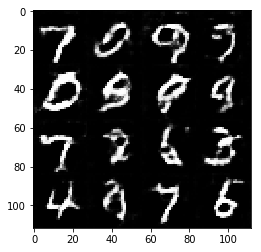

Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 1.1140
Epoch 1/2... Discriminator Loss: 0.9770... Generator Loss: 1.2310
Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 0.8509... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 0.9039
Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 0.7633
Epoch 1/2... Discriminator Loss: 0.7991... Generator Loss: 1.2494
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 1.8360
Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 0.8781
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 1.1916
Epoch 1/2... Discriminator Loss: 1.0062... Generator Loss: 1.9936
Epoch 1/2... Discriminator Loss: 0.9092... Generator Loss: 1.8645
Epoch 1/2... Discriminator Loss: 1.1248... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 0.8435... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 0.9415... Generator Loss: 0.8323
Epoch 1/2.

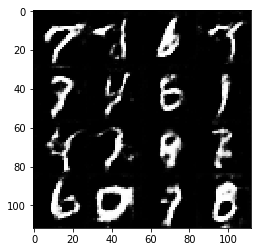

Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 0.7561... Generator Loss: 1.2028
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.2819
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 0.9712
Epoch 2/2... Discriminator Loss: 0.9163... Generator Loss: 1.4599
Epoch 2/2... Discriminator Loss: 0.8081... Generator Loss: 0.9798
Epoch 2/2... Discriminator Loss: 0.9091... Generator Loss: 0.7838
Epoch 2/2... Discriminator Loss: 1.6436... Generator Loss: 0.2754
Epoch 2/2... Discriminator Loss: 1.5499... Generator Loss: 0.3717
Epoch 2/2... Discriminator Loss: 3.2210... Generator Loss: 0.0598
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.7389
Epoch 2/2... Discriminator Loss: 1.2533... Generator Loss: 1.3935
Epoch 2/2... Discriminator Loss: 1.0889... Generator Loss: 1.6763
Epoch 2/2... Discriminator Loss: 1.1181... Generator Loss: 0.6855
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 0.6107
Epoch 2/2.

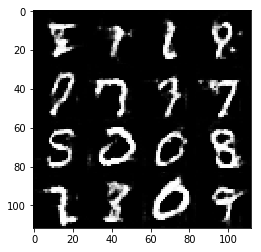

Epoch 2/2... Discriminator Loss: 0.9736... Generator Loss: 0.6805
Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 1.0262
Epoch 2/2... Discriminator Loss: 0.8863... Generator Loss: 2.1646
Epoch 2/2... Discriminator Loss: 0.9523... Generator Loss: 0.9623
Epoch 2/2... Discriminator Loss: 0.7253... Generator Loss: 1.1630
Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 0.5450
Epoch 2/2... Discriminator Loss: 0.9532... Generator Loss: 0.7178
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 0.9478
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 1.5078
Epoch 2/2... Discriminator Loss: 1.0585... Generator Loss: 2.1157
Epoch 2/2... Discriminator Loss: 1.5540... Generator Loss: 1.7131
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 1.7193
Epoch 2/2... Discriminator Loss: 0.6737... Generator Loss: 1.4789
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 1.2421... Generator Loss: 0.4881
Epoch 2/2.

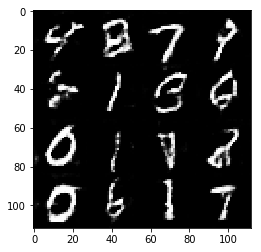

Epoch 2/2... Discriminator Loss: 1.1601... Generator Loss: 0.5028
Epoch 2/2... Discriminator Loss: 1.0232... Generator Loss: 0.6760
Epoch 2/2... Discriminator Loss: 1.5159... Generator Loss: 0.3120
Epoch 2/2... Discriminator Loss: 2.3076... Generator Loss: 0.1427
Epoch 2/2... Discriminator Loss: 3.0920... Generator Loss: 0.0796
Epoch 2/2... Discriminator Loss: 1.3233... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.7070
Epoch 2/2... Discriminator Loss: 1.2252... Generator Loss: 0.5506
Epoch 2/2... Discriminator Loss: 1.5533... Generator Loss: 0.3182
Epoch 2/2... Discriminator Loss: 1.2478... Generator Loss: 0.5314
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 0.6554
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 2.0624
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.3647
Epoch 2/2... Discriminator Loss: 1.1109... Generator Loss: 0.5900
Epoch 2/2.

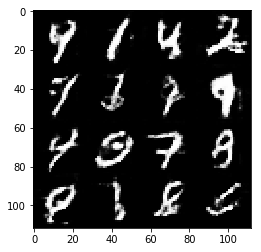

Epoch 2/2... Discriminator Loss: 0.8408... Generator Loss: 0.8424
Epoch 2/2... Discriminator Loss: 0.9364... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 0.7777... Generator Loss: 0.8945
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 1.7541
Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 1.0944
Epoch 2/2... Discriminator Loss: 0.9887... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 0.7948... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 0.5792
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 0.7613
Epoch 2/2... Discriminator Loss: 0.7456... Generator Loss: 1.0468
Epoch 2/2... Discriminator Loss: 0.7653... Generator Loss: 0.8973
Epoch 2/2... Discriminator Loss: 1.4107... Generator Loss: 0.3542
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 0.7278
Epoch 2/2... Discriminator Loss: 0.8248... Generator Loss: 1.4037
Epoch 2/2... Discriminator Loss: 1.9639... Generator Loss: 2.9732
Epoch 2/2.

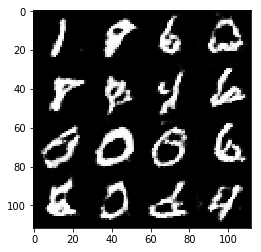

Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.5728
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 0.7385
Epoch 2/2... Discriminator Loss: 1.0212... Generator Loss: 0.6368
Epoch 2/2... Discriminator Loss: 0.8184... Generator Loss: 0.7669
Epoch 2/2... Discriminator Loss: 0.7237... Generator Loss: 0.8709
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 0.8945
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 0.5735
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.4349
Epoch 2/2... Discriminator Loss: 1.6918... Generator Loss: 0.2504
Epoch 2/2... Discriminator Loss: 1.0554... Generator Loss: 0.6007
Epoch 2/2... Discriminator Loss: 5.0354... Generator Loss: 0.0102
Epoch 2/2... Discriminator Loss: 3.8750... Generator Loss: 5.6617
Epoch 2/2... Discriminator Loss: 1.6184... Generator Loss: 0.3216
Epoch 2/2... Discriminator Loss: 1.5641... Generator Loss: 0.3688
Epoch 2/2... Discriminator Loss: 0.8891... Generator Loss: 1.3371
Epoch 2/2.

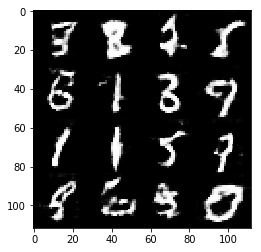

Epoch 2/2... Discriminator Loss: 0.8026... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 0.5095
Epoch 2/2... Discriminator Loss: 1.0785... Generator Loss: 0.5593
Epoch 2/2... Discriminator Loss: 0.7856... Generator Loss: 0.9624
Epoch 2/2... Discriminator Loss: 0.7614... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 1.0423... Generator Loss: 0.6254
Epoch 2/2... Discriminator Loss: 0.6976... Generator Loss: 0.9849
Epoch 2/2... Discriminator Loss: 1.0598... Generator Loss: 0.5563
Epoch 2/2... Discriminator Loss: 1.2828... Generator Loss: 0.4751
Epoch 2/2... Discriminator Loss: 0.5919... Generator Loss: 1.7687
Epoch 2/2... Discriminator Loss: 0.8254... Generator Loss: 1.1319
Epoch 2/2... Discriminator Loss: 1.3117... Generator Loss: 2.5739
Epoch 2/2... Discriminator Loss: 3.6195... Generator Loss: 4.7986
Epoch 2/2.

KeyboardInterrupt: 

In [25]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.2484... Generator Loss: 0.0026
Epoch 1/1... Discriminator Loss: 3.1595... Generator Loss: 0.1733
Epoch 1/1... Discriminator Loss: 3.2042... Generator Loss: 0.1024
Epoch 1/1... Discriminator Loss: 2.5086... Generator Loss: 0.1799
Epoch 1/1... Discriminator Loss: 2.3067... Generator Loss: 0.3483
Epoch 1/1... Discriminator Loss: 1.7152... Generator Loss: 0.4886
Epoch 1/1... Discriminator Loss: 1.1895... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 1.2561
Epoch 1/1... Discriminator Loss: 0.7919... Generator Loss: 1.8997
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 0.8250... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 0.7503... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 1.5050
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 1.7560
Epoch 1/1... Discriminator Loss: 0.6661... Generator Loss: 1.2735
Epoch 1/1.

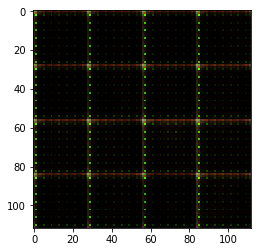

Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.0997
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 1.5743
Epoch 1/1... Discriminator Loss: 1.1303... Generator Loss: 1.1167
Epoch 1/1... Discriminator Loss: 0.8605... Generator Loss: 1.5732
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.8070
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.5972
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.3768
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.8894
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 1.5052
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 1.4796
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.0614
Epoch 1/1.

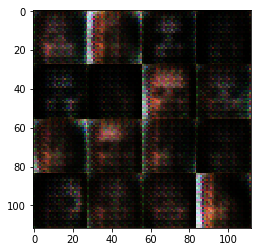

Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.5471
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6155
Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.1049
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 0.9767... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 1.0491
Epoch 1/1... Discriminator Loss: 1.6234... Generator Loss: 1.4463
Epoch 1/1... Discriminator Loss: 1.6967... Generator Loss: 2.5639
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.1946... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.3754... Generator Loss: 0.4848
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.6492
Epoch 1/1.

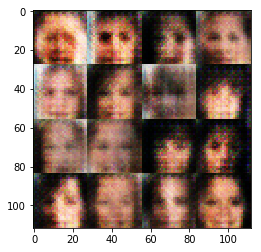

Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.9266
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.6520... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 2.0699
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 1.0387
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 1.3980
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 1.4663
Epoch 1/1.

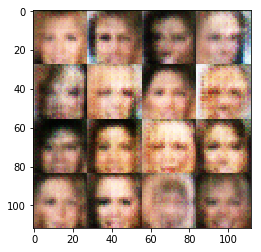

Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.4801
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.5869... Generator Loss: 1.4674
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.6750... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.5207... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.6048... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.5055
Epoch 1/1.

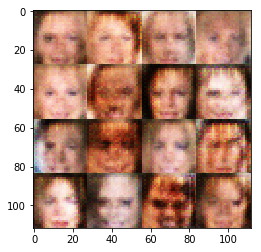

Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.6050
Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.7102
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.1403
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 1.0051
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.5575
Epoch 1/1.

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.